<a href="https://colab.research.google.com/github/Ruslan26reg/NGDM-Nesterov-with-Dirichlet-Distribution/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [9]:
class SoddaCNN(nn.Module):
    """Sodda Konvolyutsion Neyron Tarmoq"""

    def __init__(self, sinflar_soni=10):
        super(SoddaCNN, self).__init__()

        # Konvolyutsion qatlamlar
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Pooling va aktivatsiya
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # To'liq bog'langan qatlamlar
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, sinflar_soni)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [10]:
def oqitish(model, yuklagich, optimizator, kriteriya, qurilma):
    """Modelni bir davr o'qitish"""
    model.train()
    jami_yoqotish = 0
    togri = 0
    jami = 0

    for rasmlar, yorliqlar in yuklagich:
        rasmlar, yorliqlar = rasmlar.to(qurilma), yorliqlar.to(qurilma)

        optimizator.zero_grad()
        chiqish = model(rasmlar)
        yoqotish = kriteriya(chiqish, yorliqlar)
        yoqotish.backward()
        optimizator.step()

        jami_yoqotish += yoqotish.item()
        _, taxmin = torch.max(chiqish, 1)
        jami += yorliqlar.size(0)
        togri += (taxmin == yorliqlar).sum().item()

    return jami_yoqotish / len(yuklagich), 100 * togri / jami

In [11]:
def test(model, yuklagich, kriteriya, qurilma):
    """Modelni test qilish"""
    model.eval()
    jami_yoqotish = 0
    togri = 0
    jami = 0

    # Sinf bo'yicha statistika
    sinf_togri = [0] * 10
    sinf_jami = [0] * 10

    with torch.no_grad():
        for rasmlar, yorliqlar in yuklagich:
            rasmlar, yorliqlar = rasmlar.to(qurilma), yorliqlar.to(qurilma)

            chiqish = model(rasmlar)
            yoqotish = kriteriya(chiqish, yorliqlar)

            jami_yoqotish += yoqotish.item()
            _, taxmin = torch.max(chiqish, 1)
            jami += yorliqlar.size(0)
            togri += (taxmin == yorliqlar).sum().item()

            # Sinf bo'yicha hisoblash
            for i in range(len(yorliqlar)):
                label = yorliqlar[i].item()
                sinf_jami[label] += 1
                if taxmin[i] == yorliqlar[i]:
                    sinf_togri[label] += 1

    sinf_aniqlik = [100 * sinf_togri[i] / sinf_jami[i] if sinf_jami[i] > 0 else 0
                   for i in range(10)]

    return jami_yoqotish / len(yuklagich), 100 * togri / jami, sinf_aniqlik

In [12]:
def main():
    print("=" * 60)
    print("       SODDA CNN - RASM KLASSIFIKATSIYASI")
    print("=" * 60)

    # Sozlamalar
    BATCH_SIZE = 64
    DAVRLAR = 15
    OQUV_TEZLIGI = 0.001

    # Qurilma
    qurilma = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n[INFO] Qurilma: {qurilma}")

    # Transformatsiya
    oquv_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Ma'lumotlarni yuklash
    print("[INFO] Ma'lumotlar yuklanmoqda...")

    oquv_data = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=oquv_transform
    )
    test_data = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )

    oquv_yuklagich = DataLoader(oquv_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_yuklagich = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Sinf nomlari
    sinflar = ['Samolyot', 'Avtomobil', 'Qush', 'Mushuk', 'Kiyik',
               'It', 'Qurbaqa', 'Ot', 'Kema', 'Yuk mashinasi']

    print(f"[INFO] O'quv namunalari: {len(oquv_data):,}")
    print(f"[INFO] Test namunalari: {len(test_data):,}")
    print(f"[INFO] Batch o'lchami: {BATCH_SIZE}")

    # Model yaratish
    model = SoddaCNN(sinflar_soni=10).to(qurilma)
    kriteriya = nn.CrossEntropyLoss()
    optimizator = optim.Adam(model.parameters(), lr=OQUV_TEZLIGI)

    # Model ma'lumoti
    parametrlar = sum(p.numel() for p in model.parameters())
    print(f"[INFO] Model parametrlari: {parametrlar:,}")

    # Tarix
    tarix = {'oquv_yoqotish': [], 'test_yoqotish': [],
             'oquv_aniqlik': [], 'test_aniqlik': []}

    eng_yaxshi_aniqlik = 0

    # O'qitish
    print("\n" + "=" * 60)
    print("                   O'QITISH JARAYONI")
    print("=" * 60)
    print(f"{'Davr':^6}|{'O`quv Yoq':^12}|{'O`quv Aniq':^12}|{'Test Yoq':^12}|{'Test Aniq':^12}|{'Vaqt':^8}")
    print("-" * 60)

    jami_vaqt = 0

    for davr in range(1, DAVRLAR + 1):
        boshlanish = time.time()

        # O'qitish va test
        oquv_yoq, oquv_aniq = oqitish(model, oquv_yuklagich, optimizator, kriteriya, qurilma)
        test_yoq, test_aniq, sinf_aniqlik = test(model, test_yuklagich, kriteriya, qurilma)

        davr_vaqt = time.time() - boshlanish
        jami_vaqt += davr_vaqt

        # Tarixga saqlash
        tarix['oquv_yoqotish'].append(oquv_yoq)
        tarix['test_yoqotish'].append(test_yoq)
        tarix['oquv_aniqlik'].append(oquv_aniq)
        tarix['test_aniqlik'].append(test_aniq)

        # Eng yaxshi modelni saqlash
        if test_aniq > eng_yaxshi_aniqlik:
            eng_yaxshi_aniqlik = test_aniq
            torch.save(model.state_dict(), 'eng_yaxshi_model.pth')

        # Natijani chiqarish
        print(f"{davr:^6}|{oquv_yoq:^12.4f}|{oquv_aniq:^12.2f}%|{test_yoq:^12.4f}|{test_aniq:^12.2f}%|{davr_vaqt:^7.1f}s")

    print("-" * 60)

    # Yakuniy natijalar
    print("\n" + "=" * 60)
    print("                   YAKUNIY NATIJALAR")
    print("=" * 60)

    print(f"\n[NATIJA] Jami o'qitish vaqti: {jami_vaqt/60:.1f} daqiqa")
    print(f"[NATIJA] Eng yaxshi test aniqlik: {eng_yaxshi_aniqlik:.2f}%")
    print(f"[NATIJA] So'nggi o'quv aniqlik: {tarix['oquv_aniqlik'][-1]:.2f}%")
    print(f"[NATIJA] So'nggi test aniqlik: {tarix['test_aniqlik'][-1]:.2f}%")

    # Sinf bo'yicha natijalar
    print("\n" + "-" * 40)
    print("       SINF BO'YICHA ANIQLIK")
    print("-" * 40)
    for i, sinf in enumerate(sinflar):
        bar = "█" * int(sinf_aniqlik[i] / 5)
        print(f"{sinf:12s} | {sinf_aniqlik[i]:5.1f}% | {bar}")

    # Modelni saqlash
    torch.save(model.state_dict(), 'songgi_model.pth')
    print("\n[INFO] Model 'songgi_model.pth' fayliga saqlandi")
    print("[INFO] Eng yaxshi model 'eng_yaxshi_model.pth' fayliga saqlandi")

    # Grafikni chizish
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Yo'qotish grafigi
    axes[0, 0].plot(tarix['oquv_yoqotish'], 'b-', linewidth=2, label="O'quv")
    axes[0, 0].plot(tarix['test_yoqotish'], 'r-', linewidth=2, label='Test')
    axes[0, 0].set_xlabel('Davr')
    axes[0, 0].set_ylabel("Yo'qotish")
    axes[0, 0].set_title("Yo'qotish grafigi")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Aniqlik grafigi
    axes[0, 1].plot(tarix['oquv_aniqlik'], 'b-', linewidth=2, label="O'quv")
    axes[0, 1].plot(tarix['test_aniqlik'], 'r-', linewidth=2, label='Test')
    axes[0, 1].set_xlabel('Davr')
    axes[0, 1].set_ylabel('Aniqlik (%)')
    axes[0, 1].set_title('Aniqlik grafigi')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Sinf bo'yicha aniqlik
    colors = plt.cm.tab10(range(10))
    axes[1, 0].barh(sinflar, sinf_aniqlik, color=colors)
    axes[1, 0].set_xlabel('Aniqlik (%)')
    axes[1, 0].set_title("Sinf bo'yicha aniqlik")
    axes[1, 0].set_xlim(0, 100)
    for i, v in enumerate(sinf_aniqlik):
        axes[1, 0].text(v + 1, i, f'{v:.1f}%', va='center')

    # Confusion matrix o'rniga - aniqlik taqqoslash
    axes[1, 1].bar(['O\'quv', 'Test'],
                   [tarix['oquv_aniqlik'][-1], tarix['test_aniqlik'][-1]],
                   color=['blue', 'red'], alpha=0.7)
    axes[1, 1].set_ylabel('Aniqlik (%)')
    axes[1, 1].set_title('Yakuniy aniqlik taqqoslash')
    axes[1, 1].set_ylim(0, 100)
    for i, v in enumerate([tarix['oquv_aniqlik'][-1], tarix['test_aniqlik'][-1]]):
        axes[1, 1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('natijalar.png', dpi=150)
    plt.show()

    print("[INFO] Grafik 'natijalar.png' fayliga saqlandi")

    return model, tarix, sinf_aniqlik

       SODDA CNN - RASM KLASSIFIKATSIYASI

[INFO] Qurilma: cuda
[INFO] Ma'lumotlar yuklanmoqda...
[INFO] O'quv namunalari: 50,000
[INFO] Test namunalari: 10,000
[INFO] Batch o'lchami: 64
[INFO] Model parametrlari: 288,554

                   O'QITISH JARAYONI
 Davr | O`quv Yoq  | O`quv Aniq |  Test Yoq  | Test Aniq  |  Vaqt  
------------------------------------------------------------
  1   |   1.5997   |   41.52    %|   1.3052   |   53.40    %| 21.6  s
  2   |   1.2977   |   53.37    %|   1.1530   |   59.21    %| 20.5  s
  3   |   1.1602   |   58.53    %|   1.0130   |   64.38    %| 22.7  s
  4   |   1.0684   |   62.45    %|   0.9383   |   67.22    %| 21.3  s
  5   |   1.0034   |   64.75    %|   0.8920   |   68.86    %| 20.8  s
  6   |   0.9517   |   66.42    %|   0.8675   |   69.74    %| 21.6  s
  7   |   0.9080   |   68.36    %|   0.8275   |   71.31    %| 22.8  s
  8   |   0.8847   |   69.13    %|   0.8102   |   72.08    %| 23.3  s
  9   |   0.8518   |   70.14    %|   0.7888   |   7

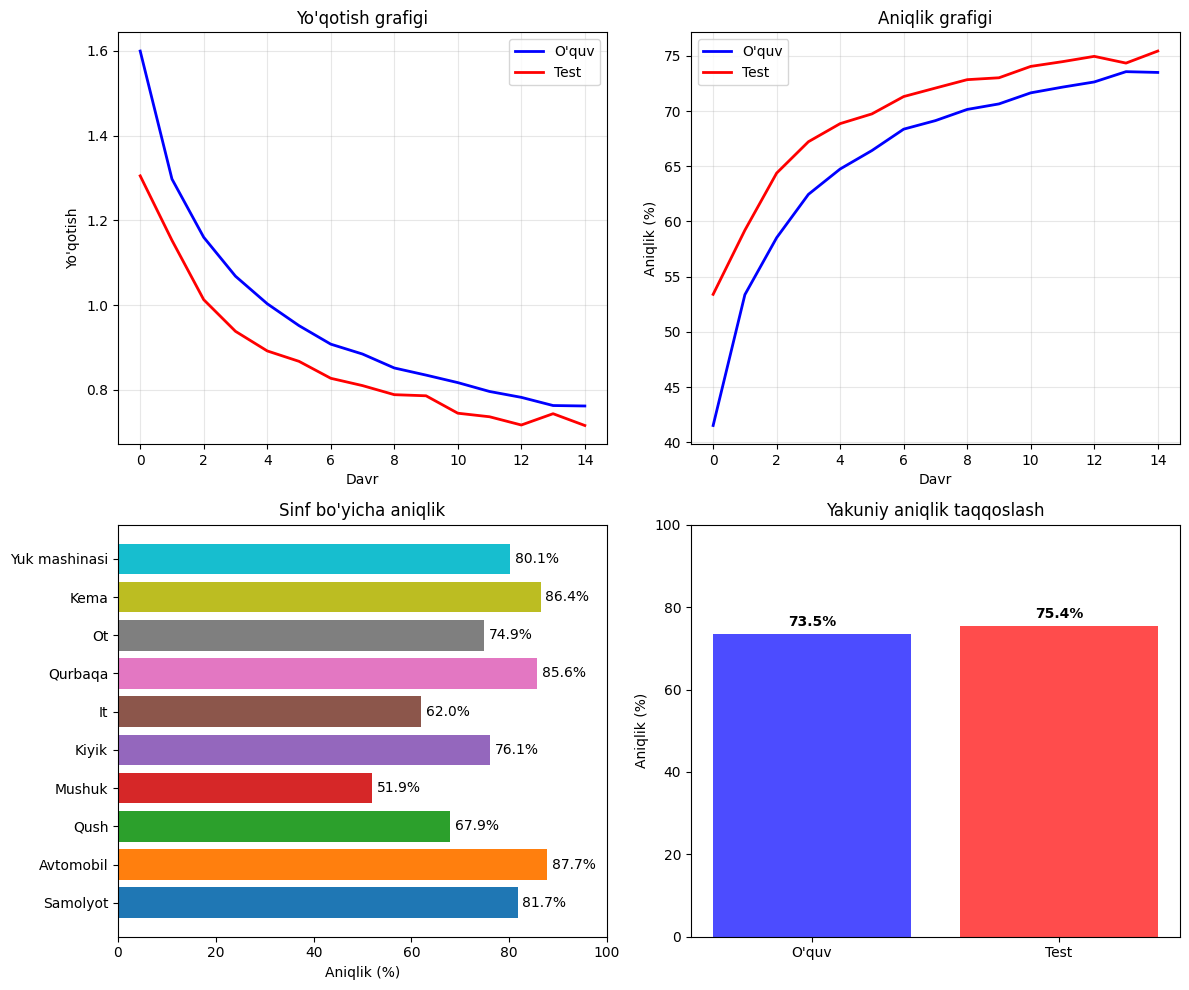

[INFO] Grafik 'natijalar.png' fayliga saqlandi


In [13]:
if __name__ == "__main__":
    model, tarix, sinf_aniqlik = main()